# Ejemplo conjunto de datos XOR

El codigo a continuación presenta un ejemplo de un conjunto de datos XOR y la implementación de una red neuronal como solución al problema de clasificación.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

## Visualización del conjunto de datos

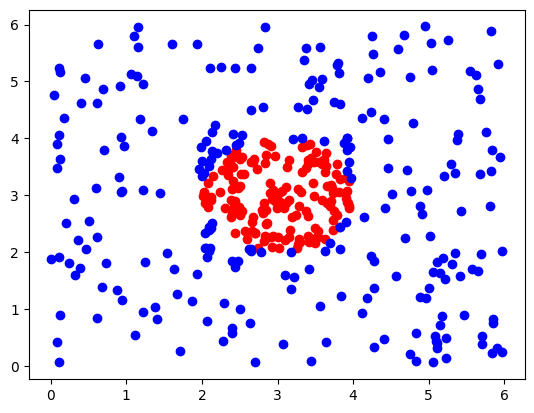

In [12]:
df = pd.read_csv('circ_data.csv', index_col=None, header=None)
df.columns = ['x1','x2','y']

clase_1 = df.loc[df.loc[:,'y'] == 0]
clase_2 = df.loc[df.loc[:,'y']==1]

plt.scatter(clase_1['x1'], clase_1['x2'], color='r')
plt.scatter(clase_2['x1'], clase_2['x2'], color='b')
plt.show()

## Separación de los datos para entrenamiento y prueba

In [13]:
# Asignamos las características y la etiqueta

X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Mezclando y asignando el conjunto de datos de entrenamiento y prueba

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]

# Normalizamos el conjunto de datos

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma


## Creación del modelo

In [14]:
DISPOSITIVO = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
class MRNSigmoideMSE(torch.nn.Module):
  def __init__(self, num_caracteristicas, num_ocultas, num_clases):
    super(MRNSigmoideMSE, self).__init__()

    self.num_clases = num_clases

    # Primera capa oculta
    self.lineal_1 = torch.nn.Linear(num_caracteristicas, num_ocultas) # Asignamos a lineal_1 como una red neuronal lineal que tiene como entrada num_caracteristicas y salida num_ocultas
    self.lineal_1.weight.detach().normal_(0.0, 0.1)                   # Inicializamos los pesos de la red neuronal con una normalización con media 0.0 y desviación estandar 0.1
    self.lineal_1.bias.detach().zero_()

    # Capa de salida
    self.lineal_salida = torch.nn.Linear(num_ocultas, num_clases)   # Asignamos a lineal_salida como una red neuronal lineal que tiene como entrada num_ocultas y salida num_clases
    self.lineal_salida.weight.detach().normal_(0.0, 0.1)            # Inicializamos los pesos de la red neuronal con una normalización con media 0.0 y desviación estandar 0.1
    self.lineal_salida.bias.detach().zero_()                        # Inicializamos las bias de la red neuronal en ceros.


  # Definimos la propagación hacia delante
  def forward(self, x):
    prediccion = self.lineal_1(x)         # La información pasa a través de la capa oculta lineal_1
    prediccion = torch.sigmoid(prediccion)    # Se aplica la función sigmoide
    prediccion = self.lineal_salida(prediccion)   # La información pasa a la capa de salida
    prediccion = torch.sigmoid(prediccion)        # Se aplica la función sigmoide una última vez en la capa de salida
    return prediccion

In [16]:
def to_onehot(y, num_clases):
  y_onehot = torch.FloatTensor(y.size(0), num_clases)
  y_onehot.zero_()
  tmp = y.view(-1, 1).long().to(torch.device('cpu'))
  y_onehot.scatter_(1, tmp, 1).float()
  return y_onehot

In [17]:
# Inicialización del modelo
torch.manual_seed(123)
modelo = MRNSigmoideMSE(num_caracteristicas = 2, # tamaño de las imágenes en pixeles
                        num_ocultas = 5,           # Capa oculta con 100 neuronas
                        num_clases = 2)             # numero de etiquetas (0-9) para identificar los números

modelo = modelo.to(DISPOSITIVO)

optimizador = torch.optim.SGD(modelo.parameters(), lr = 0.1) # lr: learning rate o velocidad de aprendizaje

## Entrenamiento del modelo

In [18]:

for epoca in range(200):

  modelo.train()
  for punto in X_train:
    # RETROPROPAGACIÓN
    Prediccion = modelo(punto)
    objetivos = y_train[(((X_train == punto).nonzero(as_tuple=True))[0])]
    y_onehot = to_onehot(objetivos, modelo.num_clases).to(DISPOSITIVO)

    costo = F.mse_loss(y_onehot, Prediccion)
    optimizador.zero_grad()

    costo.backward()

    # se actualizan los parámetros del modelo

    optimizador.step()

<ipython-input-18-468a15f7286e>:10: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  costo = F.mse_loss(y_onehot, Prediccion)


## Visualización del modelo junto con los datos

In [19]:
from matplotlib.colors import ListedColormap

def plot_regiones(X, y, clasificador, distancia_entre_puntos=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, distancia_entre_puntos),
                           np.arange(x2_min, x2_max, distancia_entre_puntos))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    funcion_activacion = clasificador.forward(tensor)
    Z = np.argmax(funcion_activacion.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)

<ipython-input-19-a50d331d2893>:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


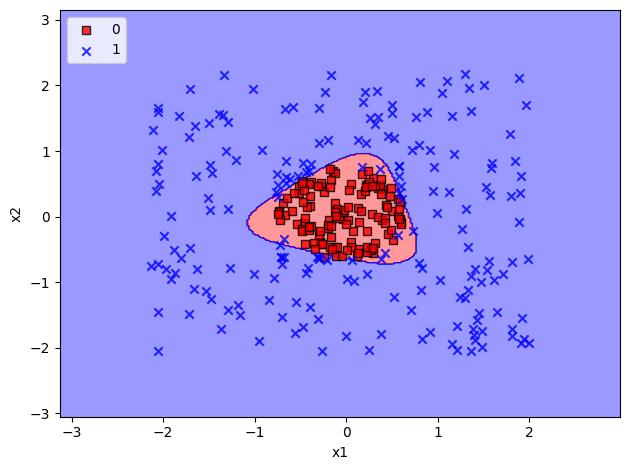

In [20]:
plot_regiones(X_train, y_train, clasificador=modelo)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()